In [2]:
from functools import wraps
from typing import List, Tuple
import mosek
import numpy as np
import scipy.sparse as sp
from numpy import linalg as LA
import cvxpy as cp
import argparse

from cvxpy.atoms import bmat, reshape, trace, upper_tri
from cvxpy.constraints.psd import PSD
from cvxpy.expressions.variable import Variable
from cvxpy.atoms.atom import Atom
from cvxpy.atoms.quad_form import QuadForm
from cvxpy.constraints.constraint import Constraint

In [3]:
import sys
sys.argv = ['']

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument("--d1", type=int, help="row dimension of the action matrix", default=5)
parser.add_argument("--d2", type=int, help="column dimension of the action matrix", default=5)
parser.add_argument("--r", type=int, help="rank of the hidden matrix", default=1)
parser.add_argument("--same", type=bool, help='Whether we should use equal strategy which is ours', default=False)
parser.add_argument("--repeat",type=int, help='How many times it will repeat for each experiment setting', default=30)
parser.add_argument("--T0",type=int, help='Length of experiment to examine', default=100000)
parser.add_argument("--sigma",type=float, help='Variance', default=1)
parser.add_argument("--delta",type=float, help='Error probability in bandit', default=0.05)
parser.add_argument("--action_set", help='which action will I use - \'hard\' is Case 1 in the figure, and \'uniform\' is the Case 2 in the figure', default='hard')
parser.add_argument("--num_of_action_set", type=int, help='Number of actions in the action set in Case 2. Case 1 has fixed number of actions', default=100),
parser.add_argument("--cheat", type=float, help='theta_0 = cheat * theta', default=0)
args = parser.parse_args()



# functions for the optimization of lasso. Basically cvxpy format functions.
def loss_fn(X, Y, beta):
    return cp.norm2(X @ beta - Y) ** 2

def regularizer(beta,d1,d2):
    return cp.norm(cp.reshape(beta, (d1,d2)), 'nuc')

def objective_fn(X, Y, beta, lambd, d1, d2):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta,d1,d2)

In [5]:
#basic settings
d1=args.d1
d2=args.d2
d=args.d1*args.d2
r=args.r
delta=args.delta

N_a = args.num_of_action_set
A= np.zeros((N_a,d))
B= np.zeros((N_a,d))
A=np.zeros((N_a,d))
for i in range(0,N_a):
    A[i]=np.random.normal(0,1,d)
    A[i]=A[i]/LA.norm(A[i])
    B[i]=(np.reshape(A[i], (d1,d2)).T).flatten()

########################## Exploration plan optimization stage ################################

mu=cp.Variable(N_a, pos=True)
X=A.T@ cp.diag(mu) @A

constraints = [cp.sum(mu)==1]
prob = cp.Problem(cp.Maximize(cp.lambda_min(X)), constraints)
prob.solve(solver=cp.MOSEK, verbose=True)

print('Optimization Finished\n')
print('Mu')
print(mu.value)
dist_hao=mu.value/np.sum(mu.value)
print('Cmin')
Cmin=prob.value
print(prob.value)

Q=A.T@ np.diag(dist_hao) @A
Q_inv=LA.inv(Q)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 17 01:02:15 AM: Your problem has 100 variables, 1 constraints, and 0 parameters.
(CVXPY) Oct 17 01:02:15 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 17 01:02:15 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 17 01:02:15 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 17 01:02:15 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Oct 17 01:02:15 AM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Co

In [6]:
def catoni_indiv(v):
    return np.sign(v)*np.log(1+np.abs(v)+v*v/2)

In [7]:
def symmetrize(X,d1,d2):
    X_mat=X.reshape((d1,d2))
    return np.block([[np.zeros((d1,d1)), X_mat],[np.transpose(X_mat), np.zeros((d2,d2))]])

In [8]:
def matrix_catoni_one(X,d1,d2, nu):
    eigenvalue, eigenvectors = LA.eig(nu*symmetrize(X,d1,d2))
    result=eigenvectors@ np.diag(catoni_indiv(eigenvalue)) @eigenvectors.T
    return result

In [9]:
def matrix_catoni(X,T0,d1,d2, nu):
    D=d1+d2
    result=np.zeros((D,D))
    for i in range(0, T0):
        result= result + matrix_catoni_one(X[i],d1,d2,nu)/T0/nu
    final_result = result[0:d1, d1:D]
    return final_result
    
    

In [10]:
def thresholding(X, threshold):
    U, S, V=LA.svd(X)
    newS=np.diag(np.abs(S)>threshold)*S
    return (U@newS)@V

In [11]:
mu=cp.Variable(N_a, pos=True)
X=A.T@ cp.diag(mu) @A
X2= B.T@ cp.diag(mu) @B

T = Variable((d, d), symmetric=True)
M = bmat([[X, np.eye(d)],
          [np.eye(d), T]])
Tsum=np.zeros([d2,d2])
T2 = Variable((d, d), symmetric=True)
M2 = bmat([[X2, np.eye(d)],
          [np.eye(d), T2]])
constraints = [M>>0, M2 >> 0, cp.sum(mu)==1]
Tsum=np.zeros([d2,d2])
Tsum2=np.zeros([d1,d1])
for i in range(0,d1):
    Tsum=Tsum+T[d2*i:d2*(i+1), :][:,d2*i:d2*(i+1)]
for j in range(0,d2):
    Tsum2=Tsum2+T2[d1*i:d1*(i+1), :][:,d1*i:d1*(i+1)]
objective = cp.Minimize(cp.maximum(cp.lambda_max(Tsum), cp.lambda_max(Tsum2)))

prob=cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK,verbose=True)

dist_our=mu.value/np.sum(mu.value)
NN=prob.value
print(prob.value)


Q=A.T@ np.diag(dist_our) @A
Q_inv_our=LA.inv(Q)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 17 01:02:33 AM: Your problem has 1350 variables, 3 constraints, and 0 parameters.
(CVXPY) Oct 17 01:02:33 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 17 01:02:33 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 17 01:02:33 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 17 01:02:33 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Oct 17 01:02:33 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

In [27]:
T0=args.T0                                      # Total number of rounds in bandit problem
repeative=args.repeat                           # How many times we repeat the same setting
sigma=args.sigma                                # Variance of the noise


hist_true=np.zeros((repeative,d))               #history of true theta
hist_esti=np.zeros((repeative,d))               #history of the estimated theta by our method
hist_esti_raw=np.zeros((repeative,d))           #history of the estimated theta by our method before thresholding
cum_regret=np.zeros((repeative,T0))             #Cumulative regret of our setting

exp_length=np.zeros(repeative)

hist_esti_hao=np.zeros((repeative,d))           #history of the estimated theta by Hao's method
cum_regret_hao=np.zeros((repeative,T0))         #Cumulative regret of the Hao's setting



for rep in range(0,repeative):
    #setting theta - changes over each experiment
    theta_v1 = np.random.normal(0,1,d1)
    theta_v1=theta_v1/LA.norm(theta_v1)
    theta_v2 = np.random.normal(0,1,d2)
    theta_v2=theta_v2/LA.norm(theta_v2)
    theta = np.matrix.flatten(np.outer(theta_v1, theta_v2))


    theta_0 = args.cheat*theta                  #PopArt can exploit pilot estimator when the agent has one. For basic setup, this cheat is always 0 and we didn't actually use it.
    a_true=A[np.argmax(A@theta)]

    # Experiment 1: PopArt experiment
    S=np.max(np.abs(A@(theta)))
    S_0=np.max(np.abs(A@(theta-theta_0)))
    T_exp=int(np.ceil(((sigma**2+S_0**2)*(r**2)*NN*(T0**2)/S_0**2)**(1/3)))
    exp_length[rep]=T_exp
    threshold_our = np.sqrt(2*NN*np.log((d1+d2)/delta)/T_exp)        
    nu_our = np.sqrt(2*np.log(2*np.max((d1,d2))/delta)/NN/T0)/(S_0+sigma)


    hist_true[rep]=theta
    X_hist=np.zeros((T_exp,d))
    cum_reg=0                                       #temporary variable for cumulative regret
    for t in range(0,T_exp):
        act_t=A[np.random.choice(N_a, p=dist_our)]
        r=theta@act_t+np.random.normal(0,sigma)
        cum_reg+=theta@(a_true-act_t)
        cum_regret[rep][t]=cum_reg
        X_hist[t]=(r-act_t@theta_0)*(Q_inv_our@act_t)+theta_0

    
    theta_1=matrix_catoni(X_hist,T_exp,d1,d2,nu_our)
    theta_hat=np.matrix.flatten(thresholding(theta_1, threshold_our))
    hist_esti[rep]=theta_hat
    for t in range(T_exp, T0):
        act_t=A[np.argmax(A@theta_hat)]
        cum_reg+=theta@(a_true-act_t)
        cum_regret[rep][t]=cum_reg


    #Experiment 2 - Botao Hao setting experiment
    T_exp_hao=int((2*(r*sigma*T0/S/Cmin)**2*np.log(d))**(1/3))
    T_exp_hao=np.min((T0, T_exp_hao))
    hist_b=np.zeros((T_exp_hao, d))                        #temporary history for the action of Hao's method, since it computes LASSO optimization
    r_b=np.zeros(T_exp_hao)                                #temporary history for the reward
    
    cum_reg_hao=0
    for t in range(0,T_exp_hao):
        act_h_t = A[np.random.choice(N_a, p=dist_hao)]
        hist_b[t]=act_h_t
        r_b[t] = theta @ act_h_t + np.random.normal(0, sigma)
        cum_reg_hao+=theta@(a_true-act_h_t)
        cum_regret_hao[rep][t]=cum_reg_hao
    beta = cp.Variable(d)
    lambd_b = 4 * sigma*np.sqrt(np.log(d)/ T_exp_hao)
    lassosol = cp.Problem(cp.Minimize(objective_fn(hist_b, r_b, beta, lambd_b,d1, d2)))
    lassosol.solve()
    beta_hat = beta.value
    hist_esti_hao[rep]=beta_hat
    a_hat_h=A[np.argmax(A@beta_hat)]
    for t in range(T_exp_hao,T0):
        act_h_t = A[np.argmax(A @ beta_hat)]
        cum_reg_hao += theta @ (a_true - act_h_t)
        cum_regret_hao[rep][t] = cum_reg_hao



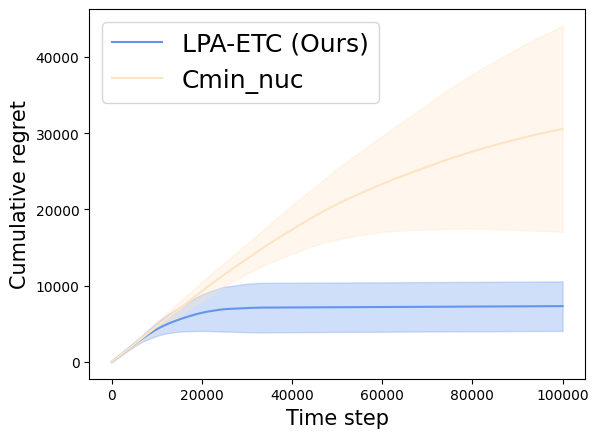

In [24]:
import matplotlib.pyplot as plt
timeline=np.linspace(1,T0, T0)
plt.xlabel('Time step', fontsize=15)
plt.ylabel('Cumulative regret', fontsize=15)
vari_our=np.std(cum_regret,axis=0)
mean_our=np.mean(cum_regret,axis=0)
vari_hao=np.std(cum_regret_hao,axis=0)
mean_hao=np.mean(cum_regret_hao,axis=0)
plt.plot(timeline, np.mean(cum_regret,axis=0), label='LPA-ETC (Ours)', color='cornflowerblue')
plt.fill_between(timeline, mean_our-vari_our, mean_our+vari_our,
    alpha=0.3, color='cornflowerblue')
plt.plot(timeline,np.mean(cum_regret_hao,axis=0), color='bisque', label='Cmin_nuc')
plt.fill_between(timeline, mean_hao-vari_hao, mean_hao+vari_hao,
    alpha=0.3, color='bisque')
plt.legend(loc=2, fontsize=18)
plt.show()

In [28]:
exp_length

array([29627., 18000., 18358.,  6774.,  7413., 19384., 18446., 29881.,
        3045., 10307., 32638., 17695., 12961.,  3763.,  8272., 12502.,
        9358., 20522.,  3707., 21455.,  8529.,  6266.,  8981., 13704.,
       12641., 18467.,  3375., 21549., 11398., 21042.])

In [37]:
threshold_our

1.1908119990904216

In [59]:
timeline

array([1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 9.9998e+04, 9.9999e+04,
       1.0000e+05])

In [39]:
sigma

0.1

In [48]:
A[1]

array([-0.32570891,  0.12901681, -0.07238214, -0.05764867, -0.04536517,
        0.12837657,  0.40265901,  0.08644254,  0.01461914,  0.13536001,
       -0.16238531,  0.07703265,  0.18115825, -0.15538554,  0.1641978 ,
        0.20615209, -0.21068425,  0.05228471,  0.16632717, -0.13672247,
        0.19919616, -0.2201705 , -0.38220065,  0.10897047,  0.40461547])

In [49]:
np.reshape(A[1], (5,5))

array([[-0.32570891,  0.12901681, -0.07238214, -0.05764867, -0.04536517],
       [ 0.12837657,  0.40265901,  0.08644254,  0.01461914,  0.13536001],
       [-0.16238531,  0.07703265,  0.18115825, -0.15538554,  0.1641978 ],
       [ 0.20615209, -0.21068425,  0.05228471,  0.16632717, -0.13672247],
       [ 0.19919616, -0.2201705 , -0.38220065,  0.10897047,  0.40461547]])

In [51]:
B=(np.reshape(A[1], (5,5)).T).flatten()

In [29]:
B

array([[-0.11589533,  0.14780652, -0.30448833, ..., -0.05600869,
         0.19687644, -0.38318611],
       [ 0.31512001,  0.0886618 ,  0.17002274, ...,  0.00428103,
         0.12754593,  0.05137123],
       [-0.01246583, -0.02882923,  0.16650127, ...,  0.25568662,
        -0.31247835,  0.19067688],
       ...,
       [-0.14846528, -0.13244992, -0.06641491, ...,  0.27116743,
        -0.30339718,  0.02800047],
       [-0.00444882, -0.0490271 ,  0.09632922, ...,  0.25014661,
        -0.08841083, -0.2816093 ],
       [-0.02783013,  0.05899011,  0.1163047 , ...,  0.26004823,
         0.21952459,  0.2874135 ]])